In [145]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib nbagg
import librosa
import jams
import librosa.display
import jams.display
import scipy
import resampy
from IPython.display import Audio

import mir_eval

import pandas as pd

In [166]:
def resample_features(X, framerate=0.25, hop_length=512, sr=22050, axis=-1, kind='linear'):
    
    times_in = librosa.frames_to_time(np.arange(X.shape[axis]), hop_length=hop_length, sr=sr)
    times_out = np.arange(times_in[0], times_in[-1], framerate)
    
    f = scipy.interpolate.interp1d(times_in, X, axis=axis, kind=kind, copy=False, assume_sorted=True)
    
    return f(times_out)

def resample_features(X, framerate=0.25, hop_length=512, sr=22050, **kwargs):
    
    return resampy.resample(X, sr/float(hop_length), 1./framerate, **kwargs)

In [3]:
def whiten(x, axis=-1):
    return (x - np.mean(x, axis=axis, keepdims=True)) / np.std(x, axis=axis, keepdims=True)

In [55]:
def selfsim(x, metric='sqeuclidean'):
    
    D = scipy.spatial.distance.cdist(x.T, x.T, metric=metric)
    bw = np.mean(np.median(D, axis=1))
    
    return np.exp(-D / bw)

def simsim(A, B):
    '''Calculates the cross-correlation between two square matrices A and B'''
    n = min(len(A), len(B))
    
    A = A[:n, :n] - np.mean(A[:n, :n])
    B = B[:n, :n] - np.mean(B[:n, :n])
    
    anorm = np.sqrt(np.sum(A[:n,:n]**2))
    bnorm = np.sqrt(np.sum(B[:n,:n]**2))
    
    return np.sum(A[:n, :n] * B[:n, :n]) / (anorm * bnorm)

In [318]:
idx = 220
#idx = 36
#idx = 254
#idx = 923
#idx = 775
#idx = 636

In [319]:
y, sr = librosa.load('/home/bmcfee/data/salami-data-public/audio/{}/audio.mp3'.format(idx))

In [320]:
j = jams.load('/home/bmcfee/git/segment_hierarchy_labels/data/SALAMI/{}.jams'.format(idx))

In [321]:
chroma = librosa.feature.stack_memory(resample_features(librosa.feature.chroma_cqt(y=librosa.effects.harmonic(y, margin=8.0),
                                                                                   sr=sr,
                                                                                   tuning=0,
                                                                                   bins_per_octave=36)),
                                      n_steps=3)

In [322]:
mfcc = librosa.feature.stack_memory(resample_features(librosa.feature.mfcc(y=y, sr=sr)), n_steps=3)

In [323]:
tgram = librosa.feature.tempogram(y=y, sr=sr)
rgram = np.abs(librosa.fmt(tgram, axis=0, n_fmt=128, t_min=0.25))

tgram = resample_features(tgram)
rgram = resample_features(rgram)

In [324]:
h1_ints, h1_labs = jams.eval.hierarchy_flatten(j.annotations['multi', 0])
h2_ints, h2_labs = jams.eval.hierarchy_flatten(j.annotations['multi', 1])

In [325]:
L1 = np.asarray(mir_eval.hierarchy._meet(h1_ints, h1_labs, 0.25).todense())
L2 = np.asarray(mir_eval.hierarchy._meet(h2_ints, h2_labs, 0.25).todense())

In [326]:
n = tgram.shape[1]

In [327]:
D_tempo = selfsim(tgram)

In [328]:
D_rhythm = selfsim(librosa.logamplitude(rgram**2, ref_power=np.max))

In [329]:
D_chroma = selfsim(chroma)

In [330]:
D_mfcc = selfsim(mfcc)

In [331]:
v1 = [simsim(L1, B) for B in [D_tempo, D_rhythm, D_chroma, D_mfcc]]
v2 = [simsim(L2, B) for B in [D_tempo, D_rhythm, D_chroma, D_mfcc]]

agreement = pd.DataFrame(columns=['Tempo', 'Rhythm', 'Chroma', 'MFCC'], data=[v1, v2], index=['A1', 'A2'])

<IPython.core.display.Javascript object>


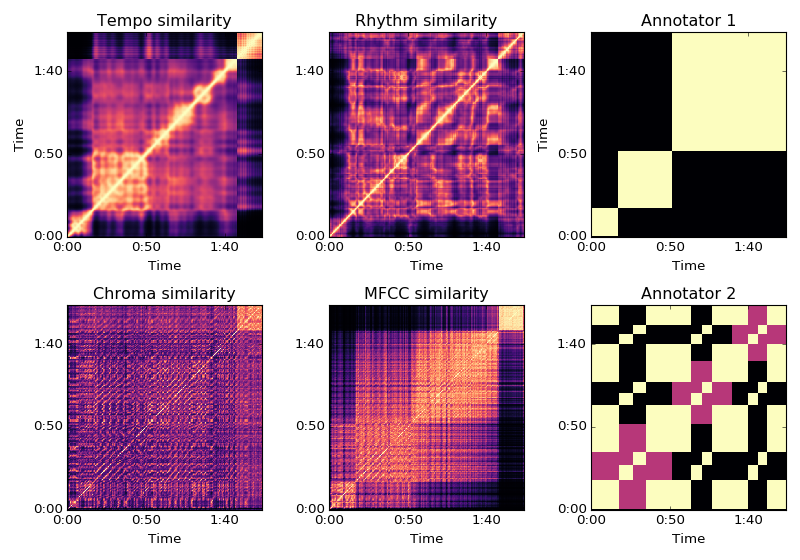

In [332]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(2,3,1)
librosa.display.specshow(D_tempo,
                         x_axis='time', y_axis='time', sr=4, hop_length=1)
plt.title('Tempo similarity')

plt.subplot(2,3,2, sharex=ax, sharey=ax)
librosa.display.specshow(D_rhythm,
                         x_axis='time', y_axis='time', sr=4, hop_length=1)
plt.ylabel('')
plt.title('Rhythm similarity')

plt.subplot(2,3,4, sharex=ax, sharey=ax)
librosa.display.specshow(D_chroma,
                         x_axis='time', y_axis='time', sr=4, hop_length=1)
plt.ylabel('')
plt.title('Chroma similarity')

plt.subplot(2,3,5, sharex=ax, sharey=ax)
librosa.display.specshow(D_mfcc,
                         x_axis='time', y_axis='time', sr=4, hop_length=1)
plt.ylabel('')
plt.title('MFCC similarity')

plt.subplot(2,3,3, sharex=ax, sharey=ax)
librosa.display.specshow(L1, x_axis='time', y_axis='time', sr=4, hop_length=1, cmap='magma')
plt.title('Annotator 1')

plt.subplot(2,3,6, sharex=ax, sharey=ax)
librosa.display.specshow(L2, x_axis='time', y_axis='time', sr=4, hop_length=1, cmap='magma')
plt.ylabel('')
plt.title('Annotator 2')

plt.tight_layout()

In [333]:
agreement

Tempo    Rhythm    Chroma      MFCC
A1  0.311968  0.255256  0.170264  0.441355
A2  0.042057  0.047572  0.041488  0.091413

In [334]:
Audio(data=y, rate=sr)

<IPython.core.display.Javascript object>


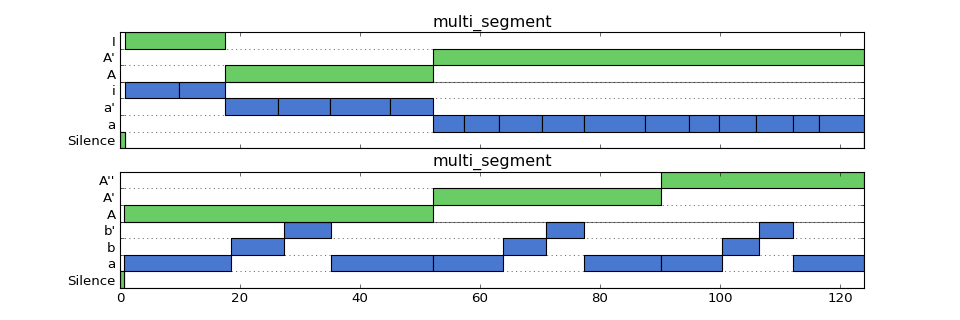

(<matplotlib.figure.Figure at 0x7f40dd530dd8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f40dd879d68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f40de0f9400>], dtype=object))

In [335]:
jams.display.display_multi(j.annotations['multi'], meta=False, fig_kw=dict(figsize=(12,4)))